<img src="Gaussian_mixtures_thumb.jpg" width=70%>

# Gaussian Mixtures Clustering for Embeddings

<h3>Code walk through video <a href="https://www.youtube.com/watch?v=">Gaussian Mixture Clustering for Embeddings</a></b></h3>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


<b>1. Word embeddings</b>

In [3]:
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")

C:\Users\18623\anaconda3\envs\transformers\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Pair of words are taken from the <a href="https://huggingface.co/datasets/phi-ai-info/support_tickets">Support Tickets dataset</a> by Phi-Ai.
Full code for Support Tickets Usecase and a way to extract the keywords is explained in <a href="https://github.com/enoten/support_ticket_analysis/blob/main/support_tickets_problem.ipynb">Support Tickets Classification notebook</a>

In [4]:
pairs = ['grant access','revoke access','access profile',
         'add user','delete user','modify user','create user',
         'disk space','disk full', 'disk error']

In [5]:
phrase_model = SentenceTransformer("all-mpnet-base-v2")

In [6]:
embeds = phrase_model.encode(pairs)

In [7]:
embeds.shape

(10, 768)

<b>2. Do dimensionality reduction</b>

In [8]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
x_embeds = embeds.copy()
X_transformed = pca.fit_transform(embeds)

In [9]:
import numpy as np
centroids = np.random.random((3,2))

In [10]:
scale = 3
centroids = centroids * np.array([[1,scale],[1,scale],[1,scale]])

In [11]:
centroid_dict = {}
for i in range(3):
    centroid_dict[i] = centroids[i,:]
centroid_dict

{0: array([0.18930622, 0.87906861]),
 1: array([0.88271673, 0.73298309]),
 2: array([0.31115109, 2.76299952])}

In [12]:
centroid_dict = {
    0: np.array([0, 0.4]),
    1: np.array([-0.2, 0.0]),
    2: np.array([0.4, -0.1]),
}

<b>3. Visualize low dim embeddings</b>

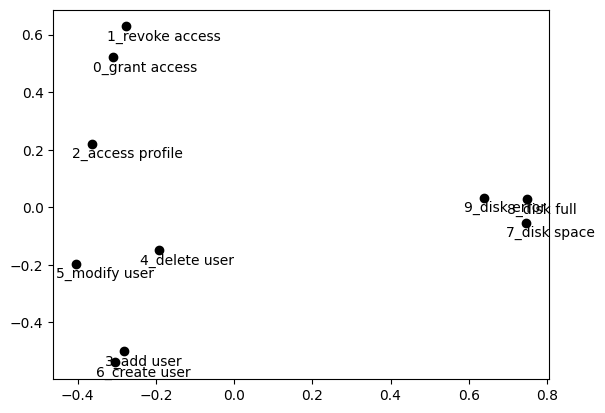

In [13]:
import matplotlib.pyplot as plt

for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black')
    plt.text(X_transformed[ind,0]-0.05,
                X_transformed[ind,1]-0.05,
                str(ind)+'_'+pairs[ind])

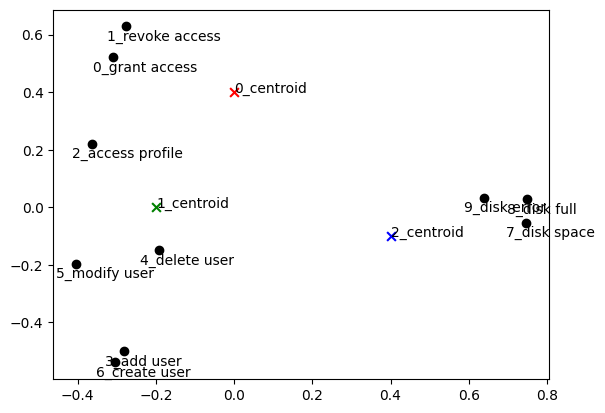

In [14]:
import matplotlib.pyplot as plt
cent_color = ['red','green','blue']
for key in centroid_dict.keys():
    plt.scatter(centroid_dict[key][0],
                centroid_dict[key][1],
                color=cent_color[key],marker='x',s=40)
    plt.text(centroid_dict[key][0],
             centroid_dict[key][1],
             str(key)+'_centroid')
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black')
    plt.text(X_transformed[ind,0]-0.05,
                X_transformed[ind,1]-0.05,
                str(ind)+'_'+pairs[ind])

<b>4. Gaussian (Normal) Distribution: from Euclidean Distance to Probability</b>

<b>4.1 1D Gaussian Distribution</b>

$$
  N(x | \mu, \sigma) = \frac{1}{\sigma\sqrt{\pi}}exp(-\frac{(x-\mu)^2}{2\sigma^2})
$$

$$
  (x-\mu)^2 = Eucleadian\_Distance^2
$$

In [15]:
def norm_1d(x,mu,sig):
    return (1/(sig*math.sqrt(math.pi)))*math.e**(-(x-mu)*(x-mu)/(2*sig*sig))

In [16]:
def plot_Gaussian(mu,
                  sigma,
                  sigma_scale=3.5,
                  show_mean=True
                 ):

    x = np.linspace(mu - sigma_scale*sigma, mu + sigma_scale*sigma, 100)
    #norm_pdf = (1/(sigma*math.sqrt(math.pi)))*math.e**(-(x-mu)*(x-mu)/(2*sigma*sigma))
    norm_pdf = norm_1d(x,mu,sigma)
    plt.plot(x, norm_pdf)
    if show_mean:
        plt.plot([mu,mu],
                 [0,max(norm_pdf)],
                 color='black',
                 linestyle='dashed',marker='o')
        #plt.text(mu+0.2,0.1,f"μ={mu}")
        plt.text(mu+0.2,0.1,f"$\mu$={mu}")
    return max(norm_pdf)

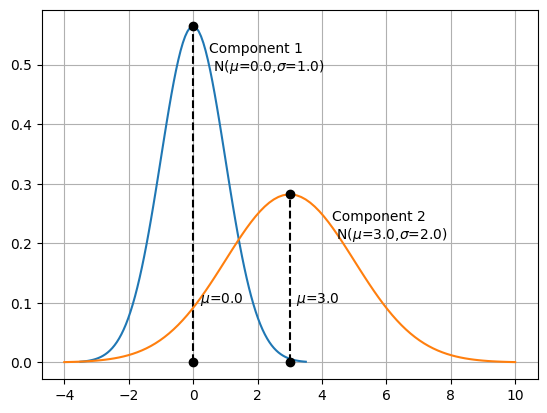

In [17]:
mus = [0.0, 3.0]
sigmas = [1.0, 2.0]
x_shift = [0.5, 1.3]
i=0
for mu,sigma in zip(mus,sigmas):
    i += 1
    max_val = plot_Gaussian(mu,sigma)
    plt.text(mu+x_shift[i-1],
             max_val-0.075,
             f"Component {i} \n N($\mu$={mus[i-1]},$\sigma$={sigmas[i-1]})")
plt.grid('on')
plt.show()

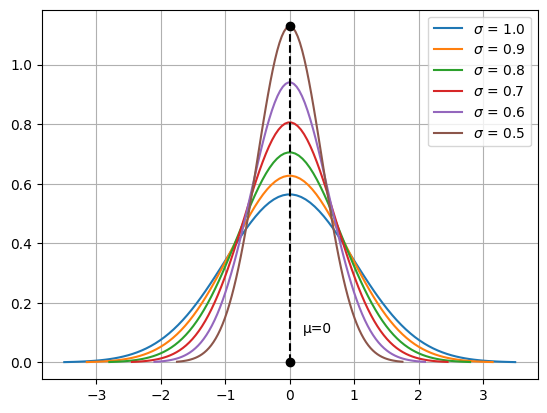

In [19]:
sigmas = np.array([1,0.9,0.8,0.7,0.6,0.5])#,0.4,0.3,0.2,0.1])
legend = [f'$\sigma$ = {sigma}' for sigma in sigmas]
for sigma in sigmas:
    max_val = plot_Gaussian(0,sigma,
                            show_mean=False)
plt.plot([0,0],
         [0,max_val],
         color='black',
         linestyle='dashed',marker='o')
plt.text(0.2,0.1,f"μ=0")
plt.legend(legend)
plt.grid('on')
plt.show()

<b>4.2 2D and Higher Dim Gaussian Distribution</b>

$x$ and $\mu$ are n$\times$1 dimentional vectors: $x_{n\times 1}$ and $\mu_{n\times 1}$.

Standard diviation $\sigma$ is becoming $n \times n$ dimentional matrix: $\Sigma_{n \times n}$

$$
    \Sigma_{n \times n} = \begin{bmatrix} 
    cov_{11} & cov_{12} & \dots & cov_{1n} \\
    cov_{21} & cov_{22} & \dots & cov_{2n} \\
    \vdots & \ddots & \\
    cov_{n1} & cov_{n2} & \dots & cov_{nn}
    \end{bmatrix}
$$

Since covariance with itself equal variance of the varaible, we substitute the main diagonal, i.e., $cov_{11}$, $cov_{22}$, ..., $cov_{nn}$, with corresponding variance values, i.e., $\sigma_{1}^2$, $\sigma_{2}^2$, ..., $\sigma_{n}^2$, respectively:

$$
    \Sigma_{n \times n} = \begin{bmatrix} 
    \sigma_{1}^2 & cov_{12} & \dots & cov_{1n} \\
    cov_{21} & \sigma_{2}^2 & \dots & cov_{2n} \\
    \vdots & \ddots & \\
    cov_{n1} & cov_{n2} & \dots & \sigma_{n}^2
    \end{bmatrix}
$$

Finally, we show explicitly show $\Sigma$ in 2D case:

$$
    \Sigma_{n \times 2} = \begin{bmatrix} 
    \sigma_{1}^2 & cov_{12} \\
    cov_{21} & \sigma_{2}^2 
    \end{bmatrix}
$$

Gaussian Distribution in N-dim space is described by the following formula:

$$
  N(x_{n{\times}1} | \mu_{n{\times}1}, \Sigma_{n{\times}n}) = \frac{1}{(2\pi)^{n/2}\sqrt{|\Sigma_{n{\times}n}|}}\exp(-\frac{1}{2}(x_{n{\times}n}-\mu_{n{\times}1})^{T} \Sigma^{-1}_{n{\times}n} (x_{n{\times}1}-\mu_{n{\times}1}))
$$

where $|\Sigma_{n{\times}n}|$ is determinant of the convariance matrix $\Sigma_{n{\times}n}$.

<b><i>Mahalanobis distance</i></b>

$$
  Mahalanobis\_distance^2 = (x_{n{\times}1}-\mu_{n{\times}1})^{T} \Sigma^{-1}_{n\times n} (x_{n{\times}1}-\mu_{n{\times}1})
$$

<b><i>Euclidean distance</i></b>

$$
  Euclidean\_distance^2 = \sum_{i=1}^n(x_{n{\times}1,i} - \mu_{n{\times}1,i})^2 = (x_{n\times 1}-\mu_{n\times 1})^{T} (x_{n\times 1}-\mu_{n\times 1})
$$

<b><i>Conclusion:</i></b> the <b><i>Mahalanobis distance</i></b> is a generalization of the <b><i>Euclidean distance</i></b>, which takes into consideration $interaction$, i.e., $covariance$, between vectors and scales vectors length in accodance with their $varainces$.

In [20]:
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.]])
Sigma 

array([[ 1. , -0.5],
       [-0.5,  1. ]])

In [21]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

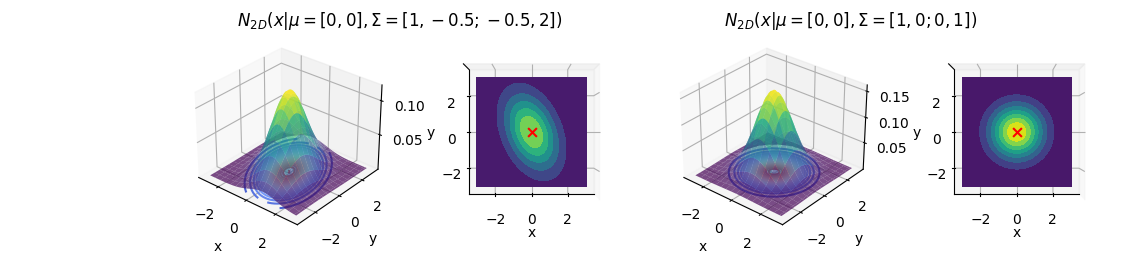

In [22]:
# Our 2-dimensional distribution will be over variables X and Y
N = 50
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 3, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  2.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure(figsize = (12,5))
ax1 = fig.add_subplot(1,4,1,projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, 
                 cstride=3, 
                 linewidth=1, 
                 antialiased=True,
                 alpha=0.7,
                 cmap=cm.viridis)

ax1.contour(X, Y, Z, 
            20, 
            zdir='z', 
            offset=0, 
            cmap='coolwarm')

ax1.view_init(30,-50)
ax1.set_xlabel(r'x')
ax1.set_ylabel(r'y')
ax1.set_title('                                           $N_{2D}(x| \mu=[0,0], \Sigma=[1, -0.5; -0.5, 2])$')


ax2 = fig.add_subplot(1,4,2,projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.set_zticks([])
ax2.set_xlabel(r'x')
ax2.set_ylabel(r'y')

ax2.scatter(0,
            0,
            color='red',
            marker='x',s=40)

# plot using subplots
Sigma = np.array([[ 1. , 0.0], [0.0,  1.]])
Z = multivariate_gaussian(pos, mu, Sigma)

ax3 = fig.add_subplot(1,4,3,projection='3d')
ax3.plot_surface(X, Y, Z, rstride=3, 
                 cstride=3, 
                 linewidth=1, 
                 antialiased=True,
                 alpha=0.7,
                 cmap=cm.viridis)

ax3.contour(X, Y, Z, 
            20, 
            zdir='z', 
            offset=0, 
            cmap='coolwarm')
ax3.view_init(30,-50)
ax3.set_xlabel(r'x')
ax3.set_ylabel(r'y')
ax3.set_title('                              $N_{2D}(x| \mu=[0,0], \Sigma=[1, 0; 0, 1])$')

ax4 = fig.add_subplot(1,4,4,projection='3d')
ax4.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax4.view_init(90, 270)
ax4.set_zticks([])
ax4.set_xlabel(r'x')
ax4.set_ylabel(r'y')

ax4.scatter(0,
            0,
            color='red',
            marker='x',s=40)
plt.show()

<b>5. Gaussian Mixtures</b>

<b>5.1 1D Gaussian Mixture</b>

$$
  Gauss\_mix (x_{n{\times}1} | p_1,...,p_k, \mu_1,...,\mu_k,\sigma_1,...,\sigma_k) = p_1 * N(x | \mu_1, \sigma_1) + ... + p_k * N(x | \mu_k,\sigma_k) 
$$

$$
  Gauss\_mix = \sum_{j=1}^{k} p_j * N(x | \mu_j, \sigma_j)
$$

$$
  \sum_{j=1}^{k} p_j = 1
$$

<b>5.2 N-dim Gaussian Mixture</b>

$$
  Gauss\_mix (x_{n{\times}1} | p_1,...,p_k, \mu_{n{\times}1,1},...,\mu_{n{\times}1,k},\Sigma_{n{\times}n,1},...,\Sigma_{n{\times}n,k}) = p_1 * N(x_{n{\times}1} | \mu_{n{\times}1,1}, \Sigma_{n{\times}n,1}) + ... + p_k * N(x_{n{\times}1} | \mu_{n{\times}1,k}, \Sigma_{n{\times}n,k}) 
$$

$$
  Gauss\_mix = \sum_{j=1}^{k} p_j * N(x_{n{\times}1,j} | \mu_{n{\times}1,j}, \Sigma_{n{\times}n,j})
$$

$$
  \sum_{j=1}^{k} p_j = 1
$$

<b>5.3 Draw 1D Gaussian Mixture</b>

In [23]:
def plot_Gaussian_mixture(mus,
                          sigmas,
                          sigma_scale=3.5):

    ranges_minus = mus-sigma_scale*sigmas
    ranges_plus = mus+sigma_scale*sigmas
    lb = ranges_minus.min()
    up = ranges_plus.max()

    x = np.linspace(lb, up, 100)

    weights = np.ones(mus.shape[0])/mus.shape[0]

    gauss_mix = 0
    components = {}
    k = -1
    for mu,sigma in zip(mus,sigmas):
        k += 1
        components[k] = norm_1d(x,mu,sigma)
        gauss_mix += weights[k]*components[k]
    plt.plot(x, gauss_mix,color='red',linewidth=2)

    for key in components:
        plt.plot(x, components[key])

    x_shift = [0.5,1.2]
    y_shift = [-0.02,-0.01]
    mix_str = 'Gauss_mix = '
    for key in components:
        max_val = max(components[key])
        plt.plot([mus[key],mus[key]],
                 [0,max_val],
                 color='black',
                 linestyle='dashed',marker='o')
        plt.text(mus[key]+0.2,
                 0.1,
                 f"$\mu$={mus[key]}")
        plt.text(mus[key]+x_shift[key],
                 max_val+y_shift[key],
                 f"Component {key+1} \n N($\mu$={mus[key]},$\sigma$={sigmas[key]})")
        mix_str += f'{weights[key]}*N($\mu$={mus[key]},$\sigma$={sigmas[key]})'
        if key < len(weights)-1:
            mix_str += ' + '
            
    plt.text(1.3,
             0.41,
             mix_str)
    plt.arrow(1.6, 0.4, -1.0, -0.1)

    plt.legend(['Gaussian Mixture'] + [f'Component {key+1}' for key in components])

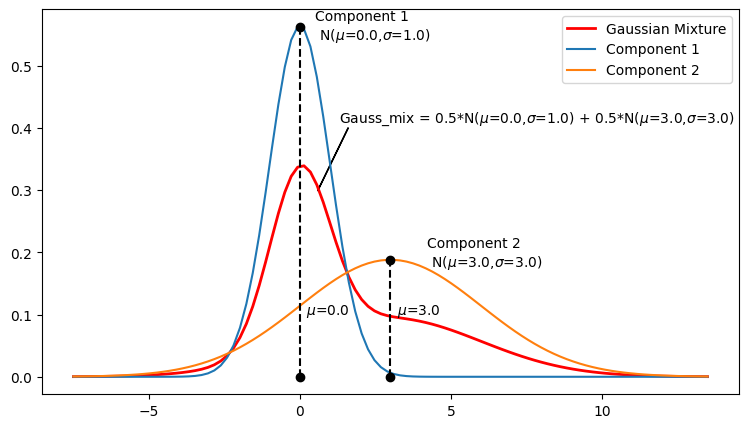

In [24]:
fig = plt.figure(figsize=(9,5))
plot_Gaussian_mixture(np.array([0.0, 3.0]),
                      np.array([1.0, 3.0]),
                          sigma_scale=3.5)

<b>5.4 Expectation–Maximization (EM) algorithm to estimate parameters of Gaussian Mixtures</b>

<b><i>Expectation Step:</i></b> for each data point compute probability to belong to each component. Select the max probability and assign data point to the corresponding mixture component.

<b><i>Maximization Step:</i></b> for each component updated mean $\mu$, convariance matrix $\Sigma$ (variance $\sigma^2$) and weight ($p$).

Mean $\mu$ is a mean of data points assigned to a given component.

Covariance matrix $\Sigma$ is covariance matrix for all data points assigned to a given component. In 1D case, we compute variance $\sigma^2$ of all data point assigned to a given component.

Weight is a ratio of number of data points assigned to a given component to the total number of data points. E.g., if there are 100 data points and 25 are assigned to a given component, weight $p$ is 0.25.

<b>6. Gaussian Mixtures Clustering</b>

<b>6.1 Cluster Assignment Step aka Expectation Step</b>

In [25]:
cov_dict = {
 0: np.array([[0.001, 0],
              [0, 0.002]]),
 1: np.array([[0.001, 0],
              [0, 0.002]]),
 2: np.array([[0.001, 0],
              [0, 0.002]])
}

In [26]:
import scipy
from scipy.stats import multivariate_normal

cluster_dict = {}
for j,data_point in enumerate(X_transformed):
    print(j,' ------ data_point',data_point, f'for pair \"{pairs[j]}\"')
    cent_dist = np.array([])
    for center in centroid_dict.keys():
        print('centroid',center,centroid_dict[center])
        dist = multivariate_normal.pdf(list(data_point),
                                               list(centroid_dict[center]),
                                               cov_dict[center]
                                              )
        cent_dist = np.append(cent_dist,dist)
    print('Probability of data point to be in ' + ' '.join([f"centroid {i}: {dis}" for i, dis in enumerate(cent_dist)]))
    cluster_index = np.argmax(cent_dist)
    print(f'Min distance is between data point and Cluster {cluster_index}: {cent_dist[cluster_index]}')
    if cluster_index in cluster_dict:
        cluster_dict[cluster_index].append(j)
    else:
        cluster_dict[cluster_index] = [j]
    print()

0  ------ data_point [-0.31082678  0.52309245] for pair "grant access"
centroid 0 [0.  0.4]
centroid 1 [-0.2  0. ]
centroid 2 [ 0.4 -0.1]
Probability of data point to be in centroid 0: 2.6724903519168338e-21 centroid 1: 4.738533140629783e-31 centroid 2: 1.5108376126762526e-150
Min distance is between data point and Cluster 0: 2.6724903519168338e-21

1  ------ data_point [-0.2754395   0.62830085] for pair "revoke access"
centroid 0 [0.  0.4]
centroid 1 [-0.2  0. ]
centroid 2 [ 0.4 -0.1]
Probability of data point to be in centroid 0: 8.279753887672948e-21 centroid 1: 9.010732142998752e-43 centroid 2: 2.4823457404280974e-155
Min distance is between data point and Cluster 0: 8.279753887672948e-21

2  ------ data_point [-0.36443973  0.22150323] for pair "access profile"
centroid 0 [0.  0.4]
centroid 1 [-0.2  0. ]
centroid 2 [ 0.4 -0.1]
Probability of data point to be in centroid 0: 5.640717076943902e-31 centroid 1: 7.120826721102554e-10 centroid 2: 8.604916435600384e-137
Min distance is bet

In [27]:
cluster_dict

{0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]}

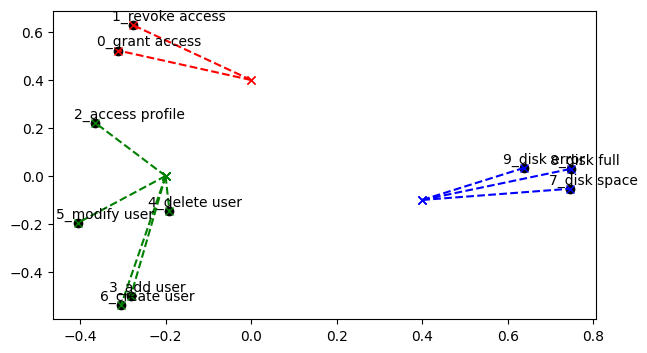

In [28]:
plt.figure(figsize=(7,4))

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,X_transformed[i,1]+0.02, str(i)+"_"+pairs[i])

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

<b>6.2 Centroid Update Step aka Maximization Step</b>

In [29]:
centroid_dict_in_time = {}  
centroid_dict_in_time[-1] = centroid_dict.copy() 

centroid_in_time = {key:[centroid_dict[key]] for key in centroid_dict.keys()}

In [30]:
iter_num = 0
for cluster_key in cluster_dict:
    #print()
    cluster_items = cluster_dict[cluster_key]
    cluster_items = np.array(cluster_items).astype(int)
    cluster_array = X_transformed[cluster_items]
    new_centroid = cluster_array.mean(axis=0)
    cov_dict[cluster_key] = np.cov(cluster_array[:,0],cluster_array[:,1],ddof=0)

    distance_between_old_new_centroid = scipy.spatial.distance.euclidean(new_centroid,centroid_dict[cluster_key])

    #print(f"old centroid {cluster_key}: {centroid_dict[cluster_key]} new centroid {cluster_key}: {new_centroid}")
    centroid_dict[cluster_key] = new_centroid.copy()
    centroid_in_time[cluster_key].append(new_centroid.copy())
centroid_dict_in_time[iter_num] = centroid_dict.copy()  

Iter num -1
Iter num 0


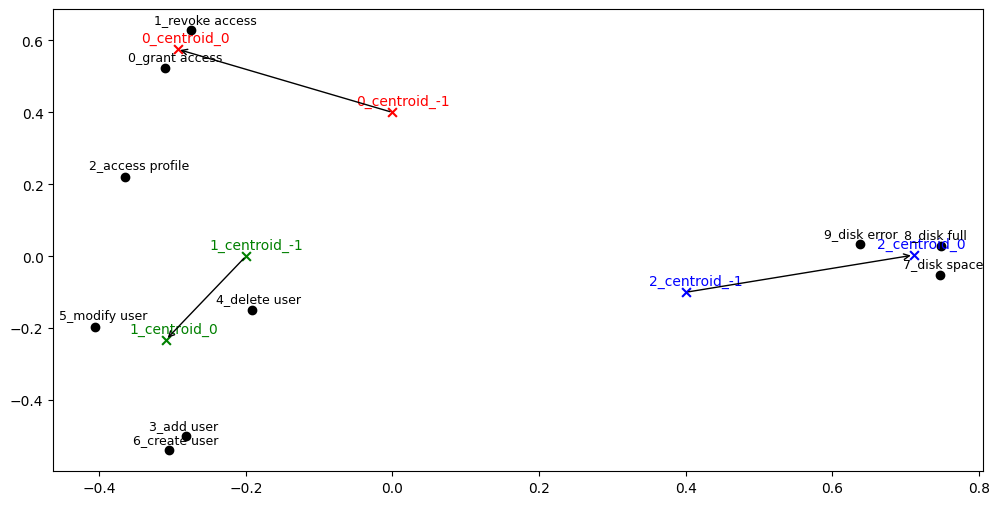

In [31]:
clust_colors = ['red','green','blue']

plt.figure(figsize=(12,6))
for iter_num in range(-1,1):
    print('Iter num',iter_num)
    centroid_dict = centroid_dict_in_time[iter_num]
    for j in centroid_dict.keys():
        plt.scatter(centroid_dict[j][0],
                    centroid_dict[j][1],
                    color=clust_colors[j],marker='x',s=40)
        plt.text(centroid_dict[j][0]-0.05,
                 centroid_dict[j][1]+0.02,
                 str(j)+'_centroid_'+str(iter_num),
                 color=clust_colors[j]
                )
    
for key in centroid_in_time:
    centroid_list = centroid_in_time[key]
    #print(len(centroid_list))
    for i in range(len(centroid_list)-1):
        #print(i)
        plt.annotate('',
                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
                     xytext=(centroid_list[i][0],centroid_list[i][1]),
                     arrowprops = dict(arrowstyle='->',color='black')
                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,
             X_transformed[i,1]+0.02, 
             str(i)+"_"+pairs[i],
             fontsize=9
            )

Cluster Assigment Step and Centroid Update Step together constitute a single epoch

<b>6.3 Run multiple epochs</b>

In [32]:
centroid_dict = {
    0: np.array([0, 0.4]),
    1: np.array([-0.2, 0.0]),
    2: np.array([0.4, -0.1]),
}

cov_dict = {
 0: np.array([[0.01, 0],
              [0, 0.01]]),
 1: np.array([[0.01, 0],
              [0, 0.01]]),
 2: np.array([[0.01, 0],
              [0, 0.01]])
}

centroid_in_time = {i:[] for i in range(3)}
for key in centroid_dict:
    centroid_in_time[key].append(centroid_dict[key])

cov_in_time = {i:[] for i in range(3)}
for key in cov_dict:
    cov_in_time[key].append(cov_dict[key])

centroid_dict_in_time = {}
centroid_dict_in_time[-1] = centroid_dict.copy()
cov_dict_in_time = {}
cov_dict_in_time[-1] = cov_dict.copy()
clusters_in_time = {}

iters = 3
for iter_num in range(iters):
    print(f"------------ Iteration {iter_num} -------------")

    print(">>>>>> Step 1: Assign Data Point to Clusters")
    #Step 1: cluster assigment step
    cluster_dict = {}
    for j,data_point in enumerate(X_transformed):
        #print(j,' ------ data_point',data_point)
        cent_dist = np.array([])
        for center in centroid_dict.keys():
            #print('centroid',center,centroid_dict[center])
            dist = multivariate_normal.pdf(list(data_point),
                                               list(centroid_dict[center]),
                                               cov_dict[center],
                                           allow_singular=True
                                              )


            cent_dist = np.append(cent_dist,dist)
        
        #print(cent_dist)
        cluster_index = np.argmax(cent_dist)
        #print('Cluster index',cluster_index)
        if cluster_index in cluster_dict:
            cluster_dict[cluster_index].append(j)
        else:
            cluster_dict[cluster_index] = [j]
            
    clusters_in_time[iter_num] = cluster_dict.copy()

    print(">>>>>> Step 2: Update centroids")
    #Step 2: centroid update step
    for cluster_key in cluster_dict:
        #print()
        cluster_items = cluster_dict[cluster_key]
        cluster_items = np.array(cluster_items).astype(int)
        
        cluster_array = X_transformed[cluster_items]
        new_centroid = cluster_array.mean(axis=0)
        cov_dict[cluster_key] = np.cov(cluster_array[:,0],cluster_array[:,1],ddof=0)    
        #print(f"old centroid {cluster_key}: {centroid_dict[cluster_key]} new centroid {cluster_key}: {new_centroid}")

        centroid_dict[cluster_key] = new_centroid.copy()
        centroid_in_time[cluster_key].append(new_centroid.copy())
        cov_in_time[cluster_key].append(cov_dict[cluster_key])
    centroid_dict_in_time[iter_num] = centroid_dict.copy()

------------ Iteration 0 -------------
>>>>>> Step 1: Assign Data Point to Clusters
>>>>>> Step 2: Update centroids
------------ Iteration 1 -------------
>>>>>> Step 1: Assign Data Point to Clusters
>>>>>> Step 2: Update centroids
------------ Iteration 2 -------------
>>>>>> Step 1: Assign Data Point to Clusters
>>>>>> Step 2: Update centroids


<b>6.4 Resulting clusters</b>

In [33]:
cluster_dict

{0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]}

In [34]:
centroid_dict_in_time

{-1: {0: array([0. , 0.4]), 1: array([-0.2,  0. ]), 2: array([ 0.4, -0.1])},
 0: {0: array([-0.29313314,  0.57569665], dtype=float32),
  1: array([-0.30921966, -0.2323269 ], dtype=float32),
  2: array([0.7107882 , 0.00341351], dtype=float32)},
 1: {0: array([-0.29313314,  0.57569665], dtype=float32),
  1: array([-0.30921966, -0.2323269 ], dtype=float32),
  2: array([0.7107882 , 0.00341351], dtype=float32)},
 2: {0: array([-0.29313314,  0.57569665], dtype=float32),
  1: array([-0.30921966, -0.2323269 ], dtype=float32),
  2: array([0.7107882 , 0.00341351], dtype=float32)}}

In [35]:
centroid_in_time

{0: [array([0. , 0.4]),
  array([-0.29313314,  0.57569665], dtype=float32),
  array([-0.29313314,  0.57569665], dtype=float32),
  array([-0.29313314,  0.57569665], dtype=float32)],
 1: [array([-0.2,  0. ]),
  array([-0.30921966, -0.2323269 ], dtype=float32),
  array([-0.30921966, -0.2323269 ], dtype=float32),
  array([-0.30921966, -0.2323269 ], dtype=float32)],
 2: [array([ 0.4, -0.1]),
  array([0.7107882 , 0.00341351], dtype=float32),
  array([0.7107882 , 0.00341351], dtype=float32),
  array([0.7107882 , 0.00341351], dtype=float32)]}

In [36]:
clusters_in_time

{0: {0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]},
 1: {0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]},
 2: {0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]}}

<b>6.5 Visualize evolution of centroids across epochs</b>

In [37]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return '#%02X%02X%02X'%(r(),r(),r())

In [38]:
import matplotlib.pyplot as plt

iter_color = ['red','green','blue','cyan']
iter_color = []
for iter_num in range(-1,iters):
    iter_color.append(random_color())
 

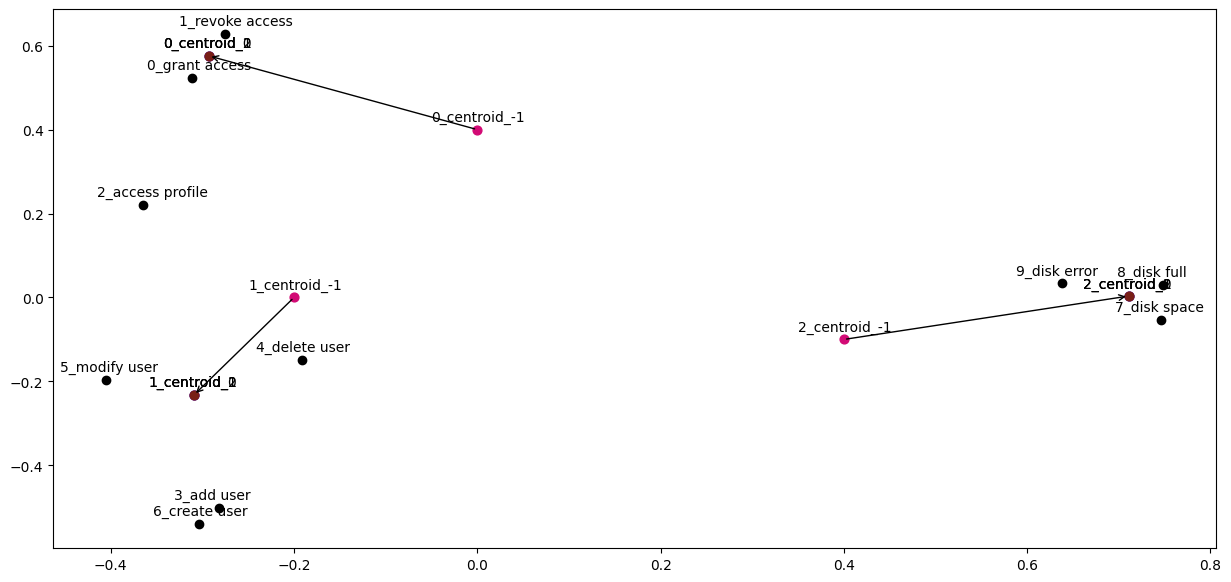

In [39]:
plt.figure(figsize=(15,7))
for iter_num in range(-1,iters):
    #print('Iter num',iter_num)
    centroid_dict = centroid_dict_in_time[iter_num]
    for j in centroid_dict.keys():
        plt.scatter(centroid_dict[j][0],centroid_dict[j][1],color=iter_color[iter_num],marker='o',s=40)
        plt.text(centroid_dict[j][0]-0.05,centroid_dict[j][1]+0.02,str(j)+'_centroid_'+str(iter_num))

for key in centroid_in_time:
    centroid_list = centroid_in_time[key]
    #print(len(centroid_list))
    for i in range(len(centroid_list)-1):
        #print(i)
        plt.annotate('',
                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
                     xytext=(centroid_list[i][0],centroid_list[i][1]),
                     arrowprops = dict(arrowstyle='->',color='black')
                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,X_transformed[i,1]+0.02, str(i)+"_"+pairs[i])

<b>6.6 Visualize Clusters</b>

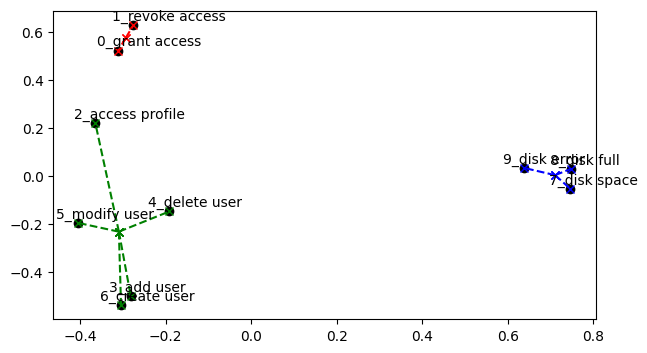

In [40]:
plt.figure(figsize=(7,4))

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,X_transformed[i,1]+0.02, str(i)+"_"+pairs[i])

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

In [41]:
var_dict = {}
corr_dict = {}
cov_dict = {}
data_dict = {}
for cluster_key in clusters_in_time[2]:
    #print()
    cluster_items = cluster_dict[cluster_key]
    cluster_items = np.array(cluster_items).astype(int)
    cluster_array = X_transformed[cluster_items]
    data_dict[cluster_key] = cluster_array
    cr = np.corrcoef(cluster_array[:,0],cluster_array[:,1])
    cov_dict[cluster_key] = np.cov(cluster_array[:,0],cluster_array[:,1],ddof=0)
    corr_dict[cluster_key] = cr[0,1]
    mu = X_transformed[cluster_items].mean(axis=0)
    std = X_transformed[cluster_items].var(axis=0)
    var_dict[cluster_key] = std#np.sqrt(std)

<b>6.7 Visualize Cluster Size</b>

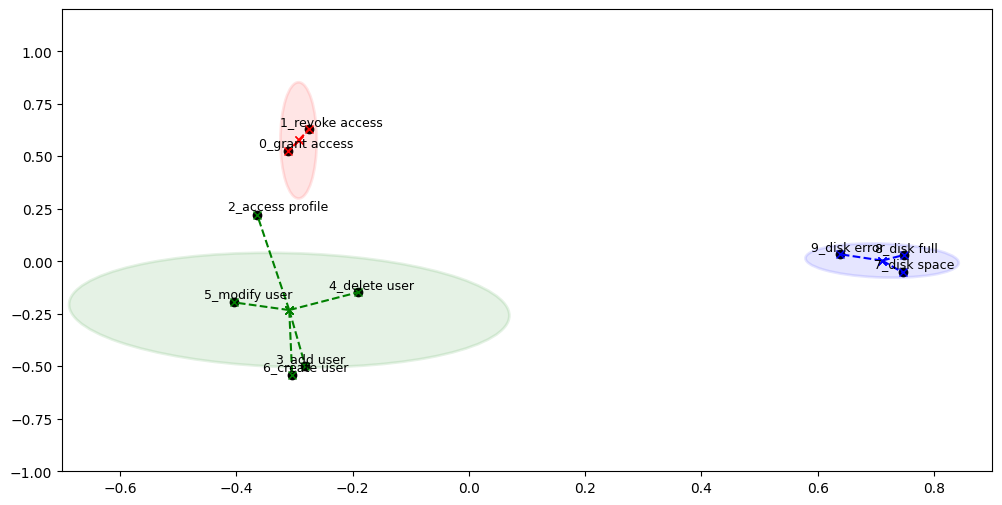

In [42]:
from matplotlib import patches
figure, axes = plt.subplots(figsize=(12,6))
#plt.figure()

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],
                X_transformed[i,1],
                marker='o',
                color="black")
    
    plt.text(X_transformed[i,0]-0.05,
             X_transformed[i,1]+0.02, 
             str(i)+"_"+pairs[i],
             fontsize=9
            )

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

scale_x = [200,100,100]
scale_y = [200,10,100]
for i,center in enumerate(centroid_dict):
   Drawing_colored_ellipse = patches.Ellipse(xy=(centroid_dict[center][0],centroid_dict[center][1]), 
                                             width=scale_x[center]*var_dict[center][0], 
                                             height=scale_y[center]*var_dict[center][1],
                                             angle=(corr_dict[center]+1)*360,
                                             #edgecolor='r', 
                                             #fc='None', 
                                             lw=2,
                                             color=clust_colors[i],
                                             alpha=0.1
                                            )
    
   #axes.set_aspect(1)
   axes.add_artist(Drawing_colored_ellipse)
plt.xlim([-0.7,0.9])
plt.ylim([-1,1.2])
#plt.title( 'Colored Circle' )
plt.show() 

In [43]:
cov_dict

{0: array([[0.00031306, 0.00093076],
        [0.00093076, 0.0027672 ]]),
 1: array([[ 0.00540463, -0.00552116],
        [-0.00552116,  0.07611334]]),
 2: array([[ 0.0026509 , -0.00107438],
        [-0.00107438,  0.00160609]])}